In [1]:
:ext LambdaCase
:ext StandaloneDeriving

In [2]:
import Utils
import Data.Tuple.Extra (uncurry3)
import Data.Bool (bool)
import Data.List.Extra (sortOn, dropEnd, enumerate)
import Data.Ord (Down(..), comparing)
import Data.Function (on, (&))
import Data.Maybe (fromJust)
import Control.Monad (replicateM, forM, forM_)
import Control.Monad.Trans.Class (lift)
import Data.IORef
import qualified Data.Map as Map

In [3]:
import Tyche.Model
import Tyche.Dist
import Tyche.Prelude
import Tyche.Prob
import Tyche.Inference.Enumerate

In [4]:
import Graphics.Vega.VegaLite hiding (filter, lookup, repeat, FontWeight(Normal))
import qualified Graphics.Vega.VegaLite as VL (filter, lookup, repeat, FontWeight(Normal))

In [5]:
data E = John | Mary | Fred deriving (Eq, Enum, Show, Bounded)

domain :: [E]
domain = enumerate

data World = World {label :: String, ht :: E -> Double}

instance Eq World where
  w == w' = show w == show w'

instance Ord World where
  compare = comparing (\s -> map (ht s) domain)

instance Show World where
  show (World l _) = l
  
type Prop = [World]

mkWorld :: (Double, Double, Double) -> World
mkWorld (d, d', d'') = World ("j" ++ show d ++ "m" ++ show d' ++ "f" ++ show d'') hts
  where hts = \case {John -> d; Mary -> d'; _ -> d''}

heights = [1 .. 11]
universe = [mkWorld (h, h', h'') | h <- heights, h' <- heights, h'' <- heights]

In [6]:
data Utt = UNone | UTall | UShrt
  deriving (Eq, Show, Ord, Enum, Bounded)

utterances :: [Utt]
utterances = enumerate

In [7]:
-- Initialize reference cell for storing results to share within and between computations
type Cache = IORef (Int, Map.Map (Int, Utt, Double) (Dist World))
cacheRef <- newIORef (0, Map.empty) :: IO Cache

In [8]:
data Priors = Priors {wp :: Model World, up :: Model Utt, tp :: Model Double}
type Agent k a = Priors -> Cache -> (Int, k, Double) -> Model a

In [9]:
alpha :: Double
alpha = 4

den :: Double -> Utt -> Prop
den _ UNone = universe
den d UTall = filter (\w -> ht w John >= d) universe
den d UShrt = filter (\w -> ht w John <= d) universe

speaker :: Agent World Utt
speaker priors ref (n,w,d) =
  do u <- up priors
     if null (den d u)
       then weight negInf
       else do lnr <- lift $ memoize ref (fmap fst . listener priors ref) (n-1,u,d)
               weight $ alpha * logProb lnr w
     return u
    
listener :: Agent Utt (World, Double)
listener priors ref (n,u,d)
  | n > 0 =
      do world <- wp priors
         thres <- if n == 1 then tp priors else return d
         spr   <- lift . enumD $ speaker priors ref (n,world,thres)
         observe spr u
         return (world, thres)
  | otherwise =
      do world <- wp priors
         condition (world `elem` den d u)
         return (world, d)

In [10]:
worldPrior :: Model World
worldPrior = do
  w <- unif universe
  forM_ domain $ \x ->
    observe (Normal 6 2) (ht w x)
  return w

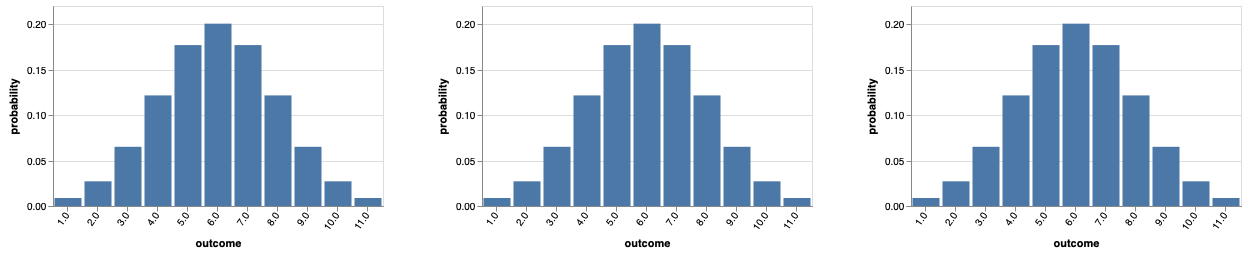

In [11]:
vlShow . sidewaysDists <$> sequence
  [ barFromDist <$> enumD ((`ht` John) <$> worldPrior)
  , barFromDist <$> enumD ((`ht` Mary) <$> worldPrior)
  , barFromDist <$> enumD ((`ht` Fred) <$> worldPrior)
  ]

In [12]:
cost :: Utt -> Double
cost UNone = 0
cost UTall = 1
cost UShrt = 2

utterancePrior :: Model Utt
utterancePrior = belief . fromList $ [(u, - alpha * cost u) | u <- utterances]

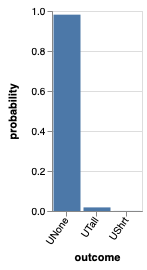

In [13]:
vlShow . barFromDist <$> enumD utterancePrior

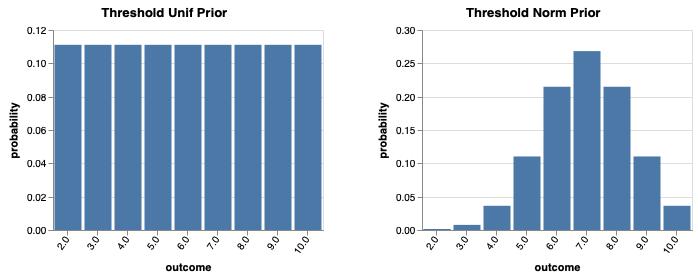

In [15]:
thresholdPriorUnif, thresholdPriorNorm :: Model Double
thresholdPriorUnif = unif (drop 1 . dropEnd 1 $ heights)
thresholdPriorNorm = thresholdPriorUnif >>= \d -> observe (Normal 7 1.5) d >> return d

vlShow . sidewaysDists <$> sequence
  [ titled "Threshold Unif Prior" . barFromDist <$> enumD thresholdPriorUnif
  , titled "Threshold Norm Prior" . barFromDist <$> enumD thresholdPriorNorm
  ]

# Experiments

Even a literal listener ought to be somewhat evaluative!

> "Tall"

In [16]:
infoBaseline = Priors worldPrior utterancePrior (unif [2])
infoLGJohnUnif = infoBaseline {tp = thresholdPriorUnif}
infoLGJohnNorm = infoBaseline {tp = thresholdPriorNorm}

In [17]:
mkGraph m = do
  heightBar <- enumD ((`ht` John) . fst <$> m)
  threshBar <- enumD (fromEnum    . snd <$> m)
  return $ toVegaLite
    [ center True
    , vConcat [fromVL (barFromDist heightBar), fromVL (sdBarFromDist heights threshBar)]
    ]

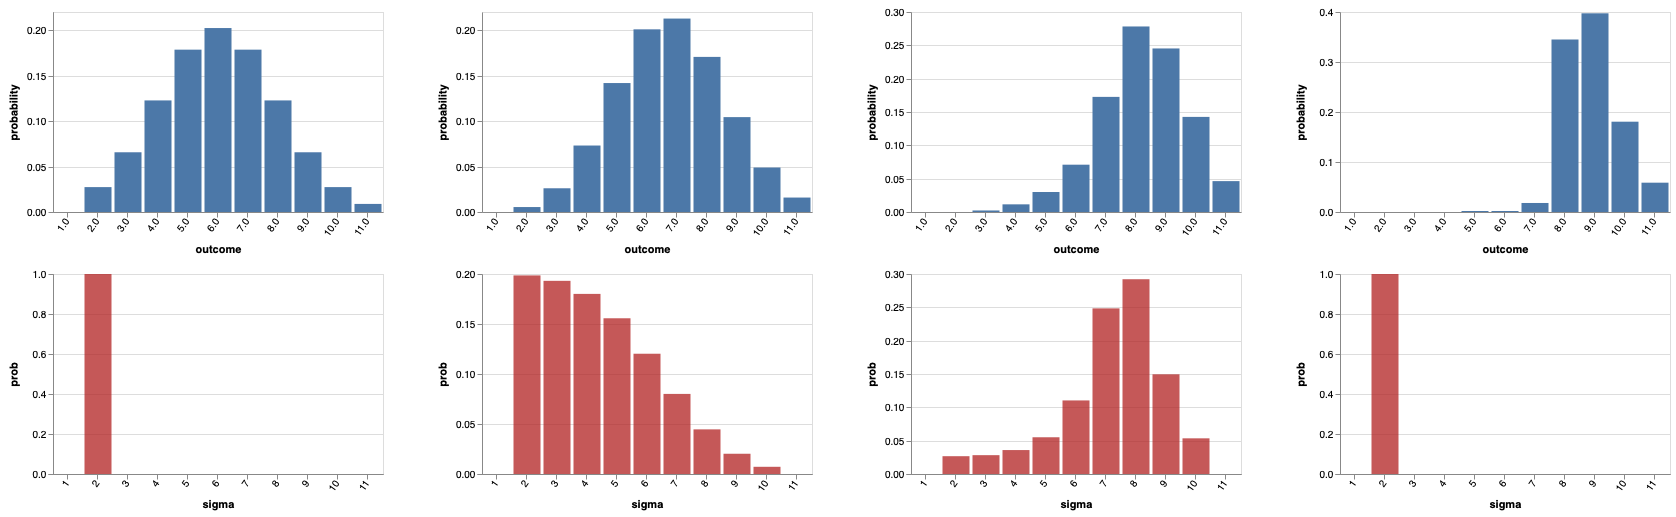

In [18]:
writeIORef cacheRef (0, Map.empty)

vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoLGJohnUnif cacheRef (0, UTall, 2)
  , tp infoLGJohnUnif >>= \l -> listener infoLGJohnUnif cacheRef (0, UTall, l)
  , listener infoLGJohnUnif cacheRef (1, UTall, 2)
  , listener infoLGJohnUnif cacheRef (2, UTall, 2)
--   , listener infoLGJohnUnif cacheRef (3, UTall, 2)
  ]

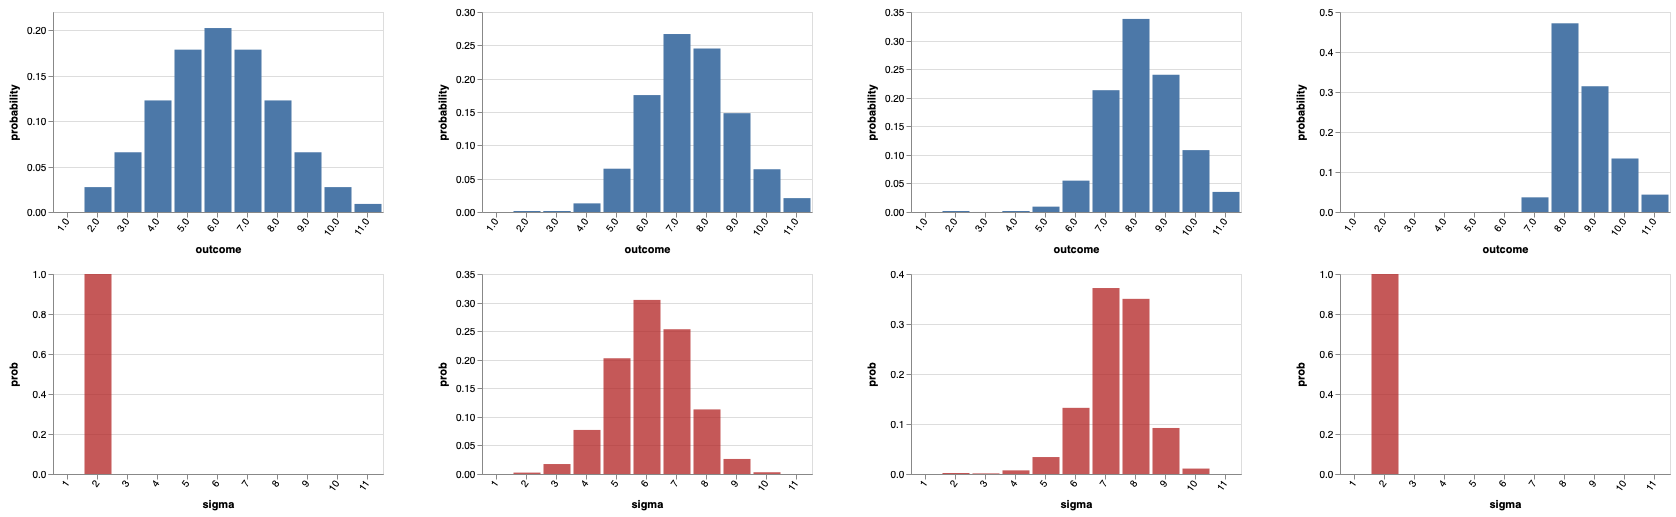

In [19]:
writeIORef cacheRef (0, Map.empty)

vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoLGJohnNorm cacheRef (0, UTall, 2)
  , tp infoLGJohnNorm >>= \l -> listener infoLGJohnNorm cacheRef (0, UTall, l)
  , listener infoLGJohnNorm cacheRef (1, UTall, 2)
  , listener infoLGJohnNorm cacheRef (2, UTall, 2)
--   , listener infoLGJohnNorm cacheRef (3, UTall, 2)
  ]